# Multinomial Logistic Regression

This is logistic regression when number of classes are more than 2.

In [1]:
import os
import math
import warnings
import numpy as np
import imageio
from matplotlib import cm
import ipywidgets as widgets
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.datasets import load_wine
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ipywidgets import interact, interactive, fixed, interact_manual

## Data Preperation

The gradient descent has the following steps:

1. Prepare your data
    - add intercept
    - $\mathbf{X}$ and $\mathbf{Y}$ and $\mathbf{W}$ in the right shape
        - $\mathbf{X}$ -> $(m, n)$
        - $\mathbf{Y}$ -> $(m, k)$
        - $\mathbf{W}$ -> $(n, k)$
        - where $k$ is number of classes
    - train-test split
    - feature scale
    - clean out any missing data
    - (optional) feature engineering

In [2]:
def plot_decision_boundary(X, y, iteration, model):
    # Create a meshgrid to cover the feature space (only using first two features)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict class labels for each point in the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    # Scatter plot the actual test points with true labels
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), edgecolors='k', marker='o', s=50, cmap=plt.cm.coolwarm)
    
    plt.title('Multiclass Logistic Regression Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.savefig(f'frames11/db_{iteration}.png')
    plt.close()

## Softmax Function
2. Predict using the softmax function
   $$ h = P(y = c \mid \boldsymbol{\theta}) = \frac{e^{\boldsymbol{\theta}^{T}_c\mathbf{x}}}{\Sigma_{i=1}^{k} e^{\boldsymbol{\theta}_k^{T}\mathbf{x}}}$$
   where c is the class
   
   --->why this function?<----
   - First, mathematically, this is just an extension of the sigmoid formula for multi-class classification
   - $e$ will always give non-negative outputs which helps, since probability is never negative
   - $e$ has a similar effect as argmax, which will turn larger input to larger outputs.
   - $e$ is super easy to differentiate, because derivative of $e$ is $e$
   - $e$ nicely cancel out the $\log$ in the cross entropy loss (see below)
   - By dividing, it make sure all the probability adds up to one.  You can think the softmax function as some form of normalization.   Why not normalization?  Because normalization cares only about proportion, while softmax reacts to change in scale better.

## Cross entropy loss

3. Calculate the loss using the cross entropy loss
    $$J = -\sum_{i=1}^m y^{(i)}\log(h^{(i)})$$
    
    Note that this is no different with the previous binary cross entropy loss.  The binary cross entropy loss is now simply extended to multiclass

In [3]:
import numpy as np

# x : raw output of model : logit
def softmax(x):
    # Compute the softmax values for each class
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Sample data
X = np.array([[1, 2, 3],
              [2, 4, 5]])  # (m, n) two samples, three features

print("X shape: ", X.shape)  # (m, n)

# Note that Y in a multi-class classification is one-hot encoded
Y = np.array([[0, 0, 1], # class  C   # (m, k) let's say three classes 
              [1, 0, 0]]) # class  A

print("Y shape: ", Y.shape)

# Weight matrix for three features and three classes (num_features X num_classes)
W = np.array([[1, 2, 3],
              [2, 3, 1],
              [1, 2, 5]])

print("W shape: ", W.shape)

# Compute the logits
logits = X @ W # XTW
print("\nX @ W (logits):\n", logits)

# Compute softmax probabilities
probabilities = softmax(logits)
print("\nSoftmax probabilities:\n", probabilities)

# Confirm that probabilities add up to 1
print("\nSum of probabilities for each sample:", probabilities.sum(axis=1))

# To find the predicted classes
predicted_classes = np.argmax(probabilities, axis=1)
print("\nPredicted classes:", predicted_classes)


X shape:  (2, 3)
Y shape:  (2, 3)
W shape:  (3, 3)

X @ W (logits):
 [[ 8 14 20]
 [15 26 35]]

Softmax probabilities:
 [[6.12898247e-06 2.47260800e-03 9.97521263e-01]
 [2.06089928e-09 1.23394576e-04 9.99876603e-01]]

Sum of probabilities for each sample: [1. 1.]

Predicted classes: [2 2]


In [4]:
# Cross-entropy loss calculation
# Step 1: Compute the negative log of the predicted probabilities
neg_log_probs = -np.log(probabilities)
print("Negative log probabilities:\n", neg_log_probs)

# Step 2: Multiply by the one-hot encoded true labels
weighted_neg_log_probs = neg_log_probs * Y
print("\nWeighted negative log probabilities:\n", weighted_neg_log_probs)

# Step 3: Sum over classes to get the loss for each sample
loss_per_sample = np.sum(weighted_neg_log_probs, axis=1)
print("\nCross-entropy loss for each sample:\n", loss_per_sample)

# Step 4: Average the loss over all samples
average_loss = np.mean(loss_per_sample)
print("\nAverage cross-entropy loss:", average_loss)

Negative log probabilities:
 [[1.20024818e+01 6.00248181e+00 2.48181414e-03]
 [2.00001234e+01 9.00012340e+00 1.23404251e-04]]

Weighted negative log probabilities:
 [[0.00000000e+00 0.00000000e+00 2.48181414e-03]
 [2.00001234e+01 0.00000000e+00 0.00000000e+00]]

Cross-entropy loss for each sample:
 [2.48181414e-03 2.00001234e+01]

Average cross-entropy loss: 10.0013026091948


# Gradient Calculation

4. Calculate the gradient of theta of feature $j$ based on the loss function $J$
    - Suppose given 2 classes (k = 2) and 3 features (n = 3), first, our y will have shape of (sample, 2), where $y_1$ refers to the probability of the sample belonging to class 1, and $y_2$ is the probability of the sample belonging to class 2.  Here $y$ sums to 1.  We have the loss function as
       $$ J = -y_1 \log h_1 - y_2 \log h_2 $$
       where $h_1$ and $h_2$ are
       $$ h_1 = \frac{\exp(g_1)}{\exp(g_1)+\exp(g_2)} $$
       $$ h_2 = \frac{\exp(g_2)}{\exp(g_1)+\exp(g_2)} $$
       where $g_1$ and $g_2$ are
       $$ g_1 = w_{11}x_1 + w_{21}x_2 + w_{31}x_3 $$
       $$ g_2 = w_{12}x_1 + w_{22}x_2 + w_{32}x_3  $$
       where in $w_{ij}$, $i$ stands for feature and $j$ stands for class 
    - For example, to find the gradient of $J$ in respect to $w_{21}$, we simply can use the chain rule (or backpropagation) to calculate like this:
       $$ \frac{\partial J}{\partial w_{21}} = \frac{\partial J}{\partial h_{1}}\frac{\partial h_{1}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}} + \frac{\partial J}{\partial h_{2}}\frac{\partial h_{2}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}}$$
   - If we know each of them, it is easy, where
       $$\frac{\partial J}{\partial h_{1}} = -\frac{y_1}{h_1}$$
       $$\frac{\partial J}{\partial h_{2}} = -\frac{y_2}{h_2}$$
       $$\frac{\partial h_{1}}{\partial g_{1}} = \frac{\exp(g_{1})}{\exp(g_{1}) + \exp(g_{2})} - (\frac{\exp(g_1)}{\exp(g_1)+\exp(g_2)})^2 = h_1 (1 - h_1)$$
       $$\frac{\partial h_{2}}{\partial g_{1}} = \frac{-exp(g_2)exp(g_1)}{(\exp(g_1) + \exp(g_2)^2} = -h_2h_1$$
       $$\frac{\partial g_1}{\partial w_{21}} = x_2$$
    - For those who forgets how to do third and fourth, recall that the quotient rule
        $$ (\frac{f}{g})' = \frac{f'g - fg'}{g^2}$$
    - Putting everything together, we got
        $$
        \begin{aligned}
        \frac{\partial J}{\partial w_{21}} &= \frac{\partial J}{\partial h_{1}}\frac{\partial h_{1}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}} + \frac{\partial J}{\partial h_{2}}\frac{\partial h_{2}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}}\\
        &= -\frac{y_1}{h_1} * h_1 (1 - h_1) * x_2 + -\frac{y_2}{h_2} * -h_2h_1 * x_2 \\
        &= x_2 (-y_1 + y_1h_1 + y_2h_1)\\
        &= x_2 (-y_1 + h_1(y_1 + y_2))\\
        &= x_2 (h_1 - y_1)\\
        \end{aligned}
        $$
     
    - Putting into matrix form, we get
        $$ \frac{\partial J}{\partial \theta} = \mathbf{X}^\top (\mathbf{H} - \mathbf{Y})$$
    - Note that both $\mathbf{H}$ and $\mathbf{Y}$ are matrices, not vectors.

5. Update the theta with this update rule
    $$\theta_j := \theta_j - \alpha * \frac{\partial J}{\partial \theta_j}$$
    where $\alpha$ is a typical learning rate range between 0 and 1
6. Loop 2-4 until max_iter is reached, or the difference between old loss and new loss are smaller than some predefined threshold tol

**Note: One good news is that the gradient turns out to be the same as past lesson!**

In [5]:
# Logistic Regression Class
class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=500, batch_size=32, n_classes=3):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.weights = None  # Will be initialized in fit()
        self.losses = []  # Track loss over iterations

    def _softmax(self, z):
        # Softmax activation function
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Numerically stable softmax
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _cross_entropy_loss(self, h, y):
        # Cross-entropy loss for multiclass classification
        return -np.mean(np.sum(y * np.log(h + 1e-15), axis=1))  # Avoid log(0)

    def _compute_loss_and_gradient(self, X, y):
        # Compute loss and gradient
        m = X.shape[0]
        h = self._softmax(np.dot(X, self.weights))
        loss = self._cross_entropy_loss(h, y)
        grad = np.dot(X.T, (h - y)) / m  # Gradient of loss w.r.t. weights
        return loss, grad

    def fit(self, X, y, save=False):
        m, n = X.shape
        self.weights = np.random.rand(n, self.n_classes)  # Initialize weights

        # Create directory to store frames if it doesn't exist
        if not os.path.exists('frames11'):
            os.makedirs('frames11')

        for i in range(self.max_iter):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                batch_X = X_shuffled[start:end]
                batch_y = y_shuffled[start:end]

                if len(batch_X) == 0:
                    continue

                loss, grad = self._compute_loss_and_gradient(batch_X, batch_y)
                self.weights -= self.learning_rate * grad  # Update weights

            epoch_loss, _ = self._compute_loss_and_gradient(X, y)
            self.losses.append(epoch_loss)

            # Plot and save the decision boundary every 10 iterations
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {epoch_loss:.4f}")
                if save: 
                    plot_decision_boundary(X[:, :2], y, i, self)

        return self

    def predict_proba(self, X):
        # Predict class probabilities
        return self._softmax(np.dot(X, self.weights))

    def predict(self, X):
        # Predict class labels
        return np.argmax(self.predict_proba(X), axis=1)

    def plot_loss(self):
        # Plot the loss over iterations
        plt.plot(range(len(self.losses)), self.losses, marker='o')
        plt.title("Loss over iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the dataset
wine = load_wine()
X = wine.data  # Features
y = wine.target  # Labels

# Create a DataFrame for better exploration
wine_df = pd.DataFrame(X, columns=wine.feature_names)
wine_df['target'] = y
wine_df.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [7]:
# Count of each class
class_counts = wine_df['target'].value_counts()
print(class_counts)

target
1    71
0    59
2    48
Name: count, dtype: int64


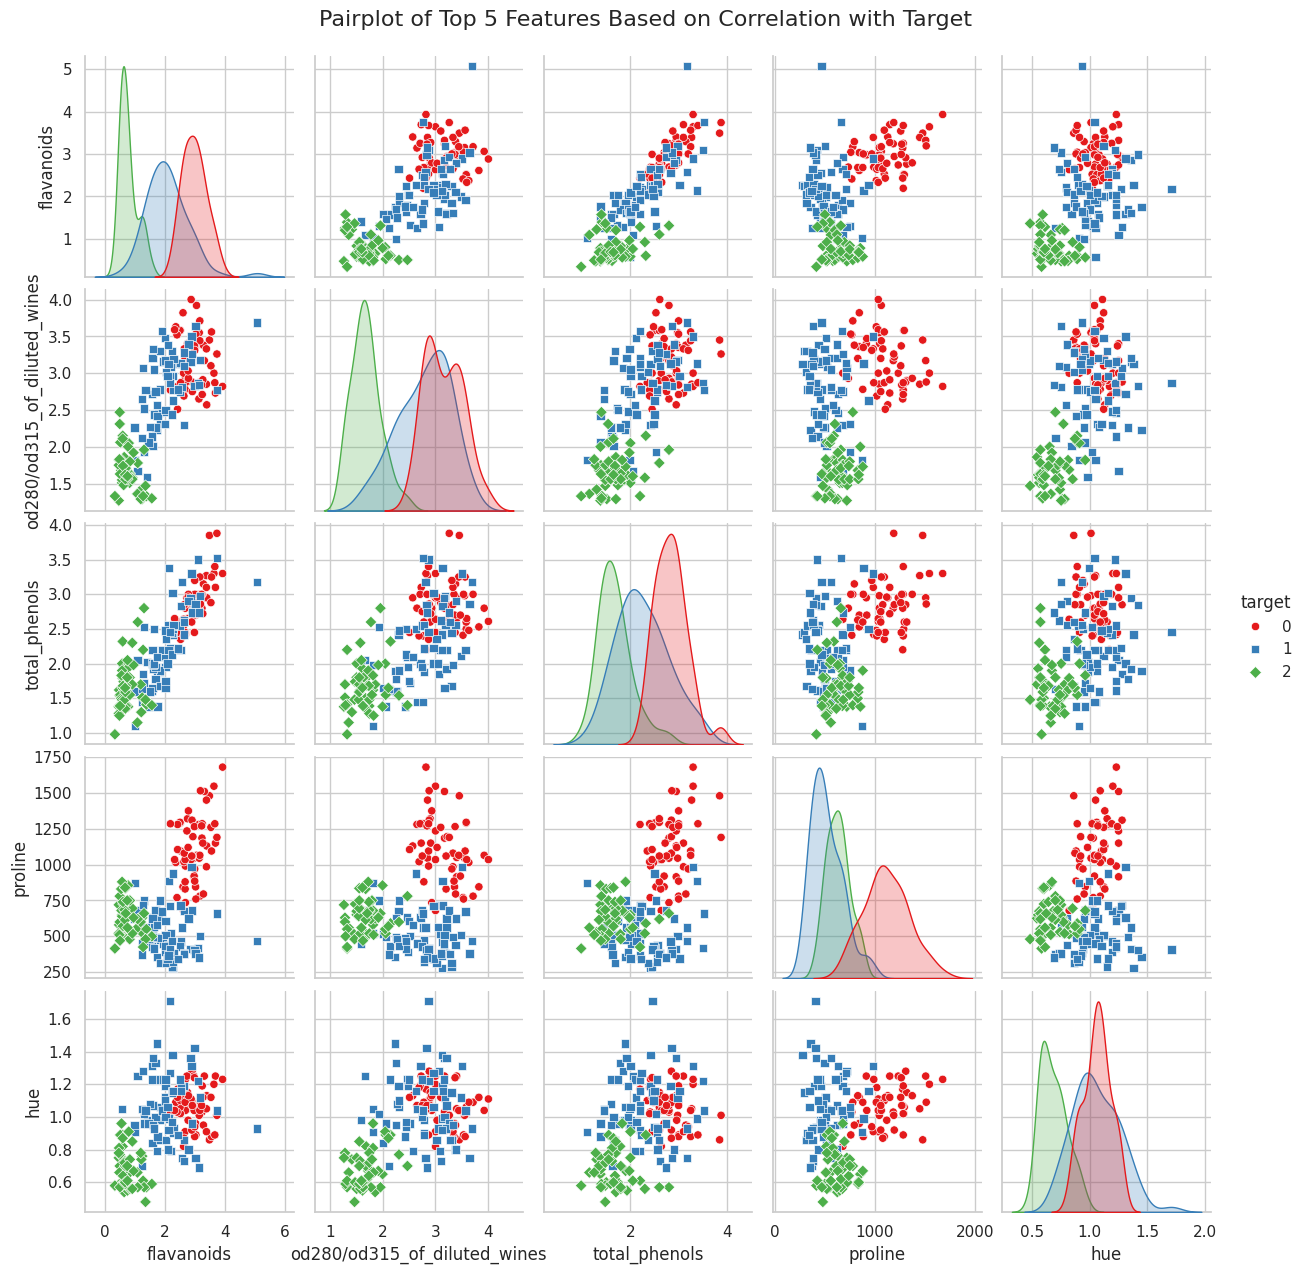

In [8]:
# Calculate the correlation matrix
correlation_matrix = wine_df.corr()

# Select the top 5 features based on correlation with the target
top_features = correlation_matrix['target'].abs().nlargest(6).index[1:]  # Exclude 'target' itself
wine_df_top5 = wine_df[top_features.tolist() + ['target']]

# Set up the aesthetics for seaborn
sns.set(style='whitegrid')

# Pairplot to visualize relationships between the top 5 features and classes
pairplot = sns.pairplot(wine_df_top5, hue='target', palette='Set1', diag_kind='kde', markers=["o", "s", "D"])
plt.suptitle('Pairplot of Top 5 Features Based on Correlation with Target', y=1.02, fontsize=16)
plt.show()

In [9]:

wine = load_wine() # Loading dataset
X = wine.data  # Features
y = wine.target  # Labels

# Preprocess the data (Standardizing)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the labels (for multiclass)
# It is very important to make the the y to be one hot encoder
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)


(124, 13) (54, 13)


Iteration 0, Loss: 0.9610
Iteration 10, Loss: 0.6630
Iteration 20, Loss: 0.5190
Iteration 30, Loss: 0.4324
Iteration 40, Loss: 0.3726
Iteration 50, Loss: 0.3277
Iteration 60, Loss: 0.2926
Iteration 70, Loss: 0.2643
Iteration 80, Loss: 0.2411
Iteration 90, Loss: 0.2218
Iteration 100, Loss: 0.2056
Iteration 110, Loss: 0.1919
Iteration 120, Loss: 0.1801
Iteration 130, Loss: 0.1699
Iteration 140, Loss: 0.1611
Iteration 150, Loss: 0.1533
Iteration 160, Loss: 0.1464
Iteration 170, Loss: 0.1403
Iteration 180, Loss: 0.1347
Iteration 190, Loss: 0.1297
Iteration 200, Loss: 0.1251
Iteration 210, Loss: 0.1209
Iteration 220, Loss: 0.1171
Iteration 230, Loss: 0.1135
Iteration 240, Loss: 0.1102
Iteration 250, Loss: 0.1071
Iteration 260, Loss: 0.1042
Iteration 270, Loss: 0.1015
Iteration 280, Loss: 0.0990
Iteration 290, Loss: 0.0966
Iteration 300, Loss: 0.0944
Iteration 310, Loss: 0.0923
Iteration 320, Loss: 0.0903
Iteration 330, Loss: 0.0884
Iteration 340, Loss: 0.0865
Iteration 350, Loss: 0.0848
Ite

Iteration 480, Loss: 0.0680
Iteration 490, Loss: 0.0670


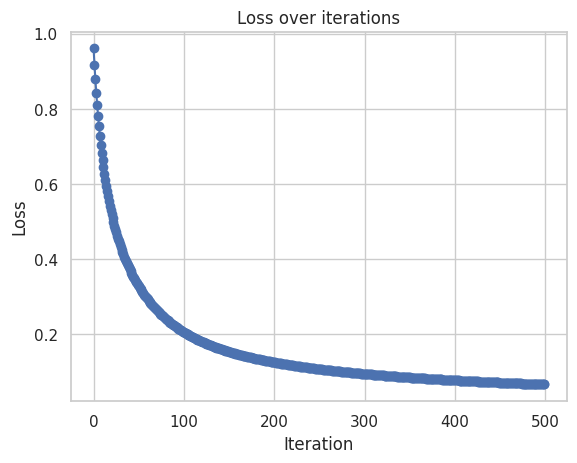

In [10]:
# Initialize and fit logistic regression model
model = MulticlassLogisticRegression(learning_rate=0.01, max_iter=500, batch_size=32)
model.fit(X_train, y_train)
# Plot loss over iterations
model.plot_loss()

In [11]:
# Evaluate the model on the test set
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Decode one-hot predictions
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Accuracy on training and test set
train_accuracy = np.mean(y_pred_train == y_train_labels) * 100
test_accuracy = np.mean(y_pred_test == y_test_labels) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 99.19%
Test Accuracy: 98.15%


In [16]:
# Using only the first two features for visualization
X_train_2d = X_train[:, :2]
X_test_2d = X_test[:, :2]

# Fit model on the reduced dataset
model_2d = MulticlassLogisticRegression(learning_rate=0.01, max_iter=500, batch_size=32)
model_2d.fit(X_train_2d, y_train, save=True)

Iteration 0, Loss: 0.9265
Iteration 10, Loss: 0.8571
Iteration 20, Loss: 0.8035
Iteration 30, Loss: 0.7617
Iteration 40, Loss: 0.7286
Iteration 50, Loss: 0.7020
Iteration 60, Loss: 0.6804
Iteration 70, Loss: 0.6625
Iteration 80, Loss: 0.6476
Iteration 90, Loss: 0.6351
Iteration 100, Loss: 0.6244
Iteration 110, Loss: 0.6153
Iteration 120, Loss: 0.6074
Iteration 130, Loss: 0.6005
Iteration 140, Loss: 0.5945
Iteration 150, Loss: 0.5892
Iteration 160, Loss: 0.5845
Iteration 170, Loss: 0.5803
Iteration 180, Loss: 0.5766
Iteration 190, Loss: 0.5733
Iteration 200, Loss: 0.5703
Iteration 210, Loss: 0.5676
Iteration 220, Loss: 0.5651
Iteration 230, Loss: 0.5629
Iteration 240, Loss: 0.5608
Iteration 250, Loss: 0.5590
Iteration 260, Loss: 0.5573
Iteration 270, Loss: 0.5558
Iteration 280, Loss: 0.5543
Iteration 290, Loss: 0.5530
Iteration 300, Loss: 0.5518
Iteration 310, Loss: 0.5507
Iteration 320, Loss: 0.5497
Iteration 330, Loss: 0.5487
Iteration 340, Loss: 0.5478
Iteration 350, Loss: 0.5470
Ite

In [17]:
images = []
for i in range(0, 500, 10):  # Adjust step based on how frequently you saved frames
    filename = f'frames11/db_{i}.png'
    images.append(imageio.imread(filename))
imageio.mimsave('db2.gif', images, fps=5)  # Save GIF

In [18]:
from helper.utils import plot_interactive_decision_boundary
# Use only the first three features for visualization purposes
X_train_3d = X_train[:, :3]
X_test_3d = X_test[:, :3]

# Initialize and train the model
model = MulticlassLogisticRegression(learning_rate=0.01, max_iter=500, batch_size=32, n_classes=3)
model.fit(X_train_3d, y_train)

# Plot the final interactive decision boundary
plot_interactive_decision_boundary(X_test_3d, y_test, model)

Iteration 0, Loss: 1.3666
Iteration 10, Loss: 1.1859
Iteration 20, Loss: 1.0477
Iteration 30, Loss: 0.9426
Iteration 40, Loss: 0.8631
Iteration 50, Loss: 0.8023
Iteration 60, Loss: 0.7554
Iteration 70, Loss: 0.7186
Iteration 80, Loss: 0.6895
Iteration 90, Loss: 0.6659
Iteration 100, Loss: 0.6467
Iteration 110, Loss: 0.6307
Iteration 120, Loss: 0.6173
Iteration 130, Loss: 0.6060
Iteration 140, Loss: 0.5964
Iteration 150, Loss: 0.5880
Iteration 160, Loss: 0.5809
Iteration 170, Loss: 0.5746
Iteration 180, Loss: 0.5691
Iteration 190, Loss: 0.5642
Iteration 200, Loss: 0.5600
Iteration 210, Loss: 0.5562
Iteration 220, Loss: 0.5528
Iteration 230, Loss: 0.5497
Iteration 240, Loss: 0.5469
Iteration 250, Loss: 0.5444
Iteration 260, Loss: 0.5421
Iteration 270, Loss: 0.5401
Iteration 280, Loss: 0.5382
Iteration 290, Loss: 0.5365
Iteration 300, Loss: 0.5349
Iteration 310, Loss: 0.5335
Iteration 320, Loss: 0.5321
Iteration 330, Loss: 0.5309
Iteration 340, Loss: 0.5298
Iteration 350, Loss: 0.5288
Ite